In [ ]:
!pip install validators matplotlib

왜 오렌지 질병 데이터셋 선택했는가?

데이터 수가 많을 것 같고 실용성이 높아 보였다.

**비교 대상 :  EfficientNetV2-XL 모델**

Pretrained Dataset : ImageNet-21k (14M 이미지, 21,843 클래스)

Parameter 수	: 208M

---


**사용할 모델 : EfficientNet B0 Wide-SE**

Pretrained Dataset : ImageNet-1k (1.28M 이미지, 1,000 클래스)

Parameter 수	: 7.8M

In [ ]:

import torch.nn as nn
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import matplotlib.image as mpimg
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_widese_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-widese-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-widese-b0_210412.pth
100%|██████████| 32.4M/32.4M [00:00<00:00, 44.6MB/s]
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
# !mkdir -p ~/.kaggle
# !cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets list

In [ ]:
# !kaggle datasets download -d jonathansilva2020/orange-diseases-dataset

In [ ]:
# !unzip orange-diseases-dataset.zip -d "/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트"

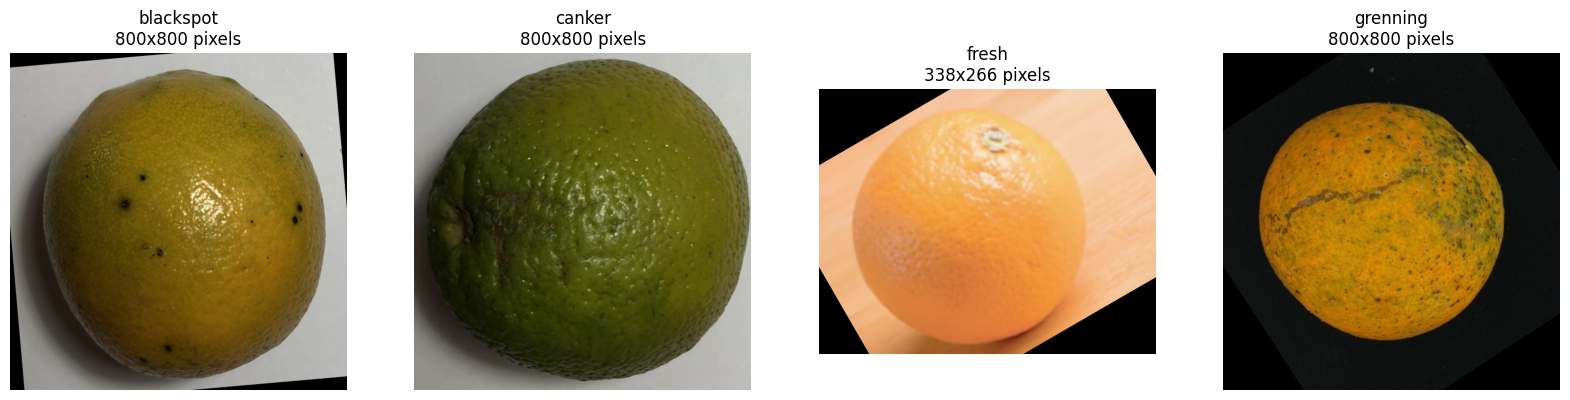

In [ ]:
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/train'

# Define the categories
categories = ['blackspot', 'canker', 'fresh', 'grenning']

# Create a dictionary to hold the path to one image from each category
image_paths = {}

for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    # List all files in the category directory
    files = os.listdir(category_dir)
    # Select the first image file (assuming there is at least one image in each category)
    if files:
        image_paths[category] = os.path.join(category_dir, files[0])

# Set up the plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Loop through each category and display the image
for ax, (category, image_path) in zip(axes, image_paths.items()):
    # Load the image
    image = mpimg.imread(image_path)
    # Get image dimensions
    height, width, _ = image.shape
    # Display the image
    ax.imshow(image)
    ax.set_title(f'{category}\n{width}x{height} pixels')
    ax.axis('off')  # Turn off the axis

# Show the plot
plt.show()

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
seed = 1234
torch.manual_seed(seed)

In [ ]:
do_data_augmentation = False

if do_data_augmentation:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomRotation(40),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                             [0.229, 0.224, 0.225])  # Imagenet std
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ 데이터셋 로드
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)

# ✅ Train/Validation Split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# ✅ Validation set은 transform 교체 필요
val_dataset.dataset.transform = val_transform

# ✅ DataLoader 준비
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ✅ 클래스 이름 가져오기
class_names = full_dataset.classes
print(f'Classes: {class_names}')
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')

Classes: ['blackspot', 'canker', 'fresh', 'grenning']
Train size: 792, Val size: 199


In [ ]:
num_classes = len(class_names)

In [ ]:
num_features = efficientnet.classifier.fc.in_features
print("기존 fc 레이어 in_features:", num_features)

기존 fc 레이어 in_features: 1280


In [ ]:
efficientnet.classifier.fc = nn.Linear(num_features, num_classes)

In [ ]:
efficientnet = efficientnet.to(device)

print("변경된 모델 구조:")
print(efficientnet)

변경된 모델 구조:
EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
     

In [ ]:
# 학습 및 평가에 필요한 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)
num_epochs = 6  # 원하는 에포크 수로 조정

for epoch in range(num_epochs):
    # Training Phase
    efficientnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train

    # Validation Phase
    efficientnet.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")


Epoch [1/6]
Train Loss: 0.2689, Train Acc: 0.9053
Val Loss: 0.8855, Val Acc: 0.7186

Epoch [2/6]
Train Loss: 0.1524, Train Acc: 0.9571
Val Loss: 0.0891, Val Acc: 0.9799

Epoch [3/6]
Train Loss: 0.0882, Train Acc: 0.9785
Val Loss: 0.4640, Val Acc: 0.9799

Epoch [4/6]
Train Loss: 0.0508, Train Acc: 0.9886
Val Loss: 1.0815, Val Acc: 0.8392

Epoch [5/6]
Train Loss: 0.0446, Train Acc: 0.9848
Val Loss: 0.1187, Val Acc: 0.9849

Epoch [6/6]
Train Loss: 0.0269, Train Acc: 0.9924
Val Loss: 0.1255, Val Acc: 0.9849



모델 구조 변경
오렌지 질병과 같은 국부적 패턴을 반영하기 위한

CBAM (Convolutional Block Attention Module) 적용

-> 공간적 영역도 반영 가능

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- CBAM 모듈 구현 ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // reduction, in_planes, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out) * x

class CBAM(nn.Module):
    def __init__(self, in_planes, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)
        return out

# --- EfficientNet의 전체 구조에 CBAM 추가하기 위한 Wrapper ---
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, base_model, cbam_channels):
        super(EfficientNetWithCBAM, self).__init__()
        # EfficientNet의 기존 구성요소들을 그대로 사용합니다.
        self.stem = base_model.stem       # 초기 컨볼루션 부분
        self.layers = base_model.layers   # MBConv 블록들이 모여있는 부분
        self.features = base_model.features   # 마지막 특징 추출 부분 (보통 채널 수 1280)
        # features 이후에 CBAM 모듈을 추가
        self.cbam = CBAM(cbam_channels)
        # classifier는 이미 avgpool, flatten, dropout, fc를 포함하고 있음
        self.classifier = base_model.classifier

    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.features(x)
        # 여기서 CBAM을 적용합니다.
        x = self.cbam(x)
        # classifier를 통해 pooling, flatten 및 최종 분류를 수행합니다.
        x = self.classifier(x)
        return x

# CBAM에 사용할 채널 수는 features의 출력 채널 수 (예: 1280)로 설정합니다.
cbam_channels = 1280  # efficientnet.features의 마지막 conv 출력 채널

# 기존 efficientnet 모델을 기반으로 CBAM이 추가된 모델 생성
model_with_cbam = EfficientNetWithCBAM(efficientnet, cbam_channels)
model_with_cbam = model_with_cbam.to(device)

print("CBAM이 추가된 전체 EfficientNet 모델 구조:")
print(model_with_cbam)


CBAM이 추가된 전체 EfficientNet 모델 구조:
EfficientNetWithCBAM(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_

In [ ]:
import torch
import torch.nn as nn

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_with_cbam.parameters(), lr=0.001)
num_epochs = 6

for epoch in range(num_epochs):
    # 학습 단계
    model_with_cbam.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_with_cbam(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # 검증 단계
    model_with_cbam.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_with_cbam(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")


Epoch [1/6]
Train Loss: 0.0931, Train Acc: 0.9836
Val Loss: 0.3152, Val Acc: 0.9698

Epoch [2/6]
Train Loss: 0.0440, Train Acc: 0.9836
Val Loss: 0.3312, Val Acc: 0.9698

Epoch [3/6]
Train Loss: 0.0792, Train Acc: 0.9836
Val Loss: 0.3938, Val Acc: 0.9347

Epoch [4/6]
Train Loss: 0.0255, Train Acc: 0.9924
Val Loss: 1.4004, Val Acc: 0.8442

Epoch [5/6]
Train Loss: 0.0344, Train Acc: 0.9861
Val Loss: 0.8343, Val Acc: 0.8442

Epoch [6/6]
Train Loss: 0.0342, Train Acc: 0.9912
Val Loss: 0.4744, Val Acc: 0.9397



OneCycleLR 스케줄러를 활용한 학습률 스케줄링 적용.

In [ ]:
import torch
import torch.nn as nn

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_with_cbam.parameters(), lr=0.001)

num_epochs = 6
# OneCycleLR 스케줄러: steps_per_epoch와 전체 에포크를 지정하면 내부적으로 warmup 및 cosine annealing이 적용됩니다.
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,                      # 최대 학습률 (학습 초기에 도달)
    steps_per_epoch=len(train_loader), # 각 에포크의 배치 수
    epochs=num_epochs
)

for epoch in range(num_epochs):
    model_with_cbam.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_with_cbam(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # 배치마다 학습률 업데이트 (워밍업 + Cosine Annealing)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # 검증 단계
    model_with_cbam.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_with_cbam(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")


Epoch [1/6]
Train Loss: 0.0361, Train Acc: 0.9848
Val Loss: 0.1849, Val Acc: 0.9698

Epoch [2/6]
Train Loss: 0.0323, Train Acc: 0.9924
Val Loss: 0.3516, Val Acc: 0.9397

Epoch [3/6]
Train Loss: 0.0294, Train Acc: 0.9937
Val Loss: 0.2472, Val Acc: 0.9799

Epoch [4/6]
Train Loss: 0.0026, Train Acc: 1.0000
Val Loss: 0.2250, Val Acc: 0.9698

Epoch [5/6]
Train Loss: 0.0011, Train Acc: 1.0000
Val Loss: 0.1921, Val Acc: 0.9749

Epoch [6/6]
Train Loss: 0.0045, Train Acc: 0.9987
Val Loss: 0.1792, Val Acc: 0.9749



증강 및 정규화 적용

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# ---------------------------
# 1. 고급 증강: Cutout 변환 정의
# ---------------------------
class Cutout(object):
    """
    입력 텐서에 대해 임의 위치의 사각형 영역을 0으로 마스킹합니다.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes  # 마스킹할 영역의 수
        self.length = length    # 사각형 영역의 크기

    def __call__(self, img):
        # img: (C, H, W) 텐서
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        return img * mask

# ---------------------------
# 2. 데이터 증강 transform 정의
# ---------------------------
IMAGE_SIZE = (512, 512)  # 원하는 이미지 크기
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    Cutout(n_holes=1, length=64),
    transforms.Normalize(mean, std)
])

# Validation에는 증강 없이 리사이즈와 Normalize만 적용
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ---------------------------
# 3. 데이터셋 및 DataLoader 구성 (기존 dataset_dir, seed, BATCH_SIZE 변수 사용)
# ---------------------------
# full_dataset은 ImageFolder를 사용한다고 가정
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)

# Train/Validation 80/20 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Validation은 증강 대신 단순 transform 적용
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ---------------------------
# 4. Mixup 기법 함수 정의
# ---------------------------
def mixup_data(x, y, alpha=0.4):
    """
    Mixup을 적용하여 두 입력 및 레이블을 섞습니다.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Mixup loss: 두 레이블에 대한 가중 손실 합산.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------------------
# 5. 모델, 손실 함수, 옵티마이저, 스케줄러 설정
# ---------------------------
# (이미 CBAM이 추가된 model_with_cbam와 device는 이전 코드에서 생성됨)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_with_cbam.parameters(), lr=0.001)

num_epochs = 6

# OneCycleLR 스케줄러 (워밍업 + 코사인 Annealing)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs
)

use_mixup = True  # Mixup 기법 사용 여부

# ---------------------------
# 6. 학습 루프 (6 에포크)
# ---------------------------
for epoch in range(num_epochs):
    model_with_cbam.train()
    running_loss = 0.0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixup 기법 적용 여부에 따라
        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)
            outputs = model_with_cbam(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model_with_cbam(images)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()  # 배치마다 학습률 업데이트

        running_loss += loss.item() * images.size(0)
        total_train += images.size(0)

    train_loss = running_loss / total_train

    # Validation 단계 (Mixup 없이 평가)
    model_with_cbam.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_with_cbam(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += images.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    if use_mixup:
        print(f"Train Loss: {train_loss:.4f} (Mixup applied)")
    else:
        print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")


Epoch [1/6]
Train Loss: 0.8520 (Mixup applied)
Val Loss: 0.1884, Val Acc: 0.9598

Epoch [2/6]
Train Loss: 0.5004 (Mixup applied)
Val Loss: 0.3601, Val Acc: 0.8794

Epoch [3/6]
Train Loss: 0.4467 (Mixup applied)
Val Loss: 0.1900, Val Acc: 0.9749

Epoch [4/6]
Train Loss: 0.3605 (Mixup applied)
Val Loss: 0.1283, Val Acc: 0.9749

Epoch [5/6]
Train Loss: 0.3191 (Mixup applied)
Val Loss: 0.1153, Val Acc: 0.9749

Epoch [6/6]
Train Loss: 0.3461 (Mixup applied)
Val Loss: 0.1128, Val Acc: 0.9749



달라진게 없음 왜그런가?

애초에 데이터셋이 증강된 데이터셋이라서 의미가 없어보인다.


데이터 시각화 + 데이터 전처리를 통한 성능 향상

6에폭 뿐만 아닌 추가 학습을 통한 성능 향상

---



In [ ]:
import os
import warnings
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings('ignore')
%matplotlib inline

# device 설정
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


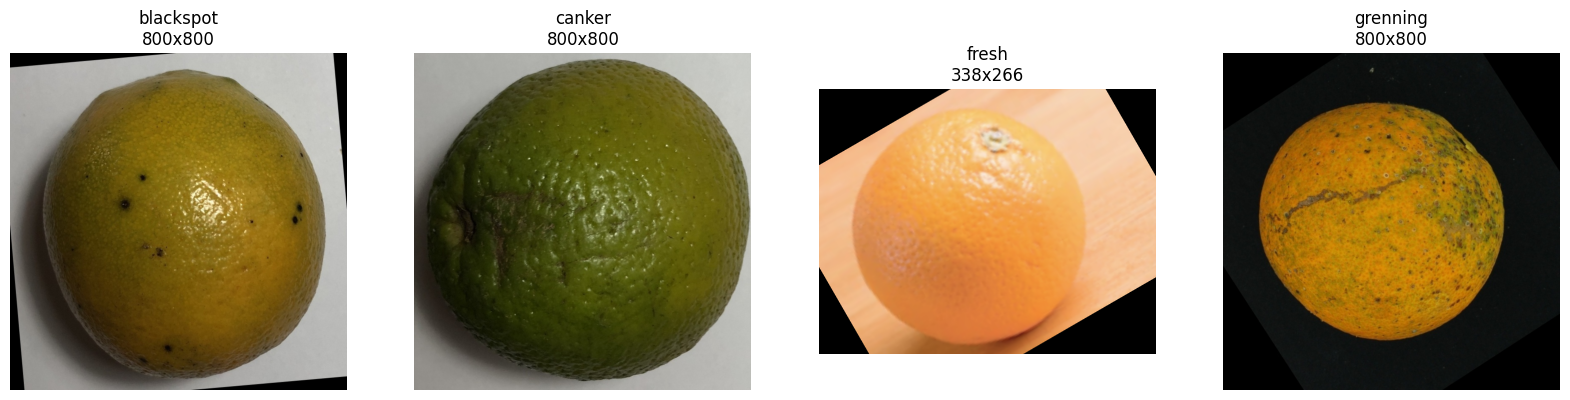

In [ ]:
# 셀 2: 데이터 경로 및 카테고리, 이미지 시각화
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/train'
categories = ['blackspot', 'canker', 'fresh', 'grenning']

# 각 카테고리에서 한 개의 이미지를 불러와 시각화
image_paths = {}
for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    files = os.listdir(category_dir)
    if files:
        image_paths[category] = os.path.join(category_dir, files[0])

fig, axes = plt.subplots(1, len(categories), figsize=(20, 5))
for ax, (category, img_path) in zip(axes, image_paths.items()):
    image = mpimg.imread(img_path)
    h, w, _ = image.shape
    ax.imshow(image)
    ax.set_title(f'{category}\n{w}x{h}')
    ax.axis('off')
plt.show()


In [ ]:
# 셀 3: 기본 데이터 전처리 및 DataLoader 구성
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
seed = 1234
torch.manual_seed(seed)

# 데이터 증강 여부에 따라 transform 설정
do_data_augmentation = False
if do_data_augmentation:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomRotation(40),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# validation은 증강 없이 동일한 사이즈로
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ImageFolder를 이용한 전체 데이터셋 로드 및 Train/Validation 분할 (80/20)
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(seed))
# validation set은 별도의 transform 적용
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 클래스 이름 출력
class_names = full_dataset.classes
print(f'Classes: {class_names}')
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')


Classes: ['blackspot', 'canker', 'fresh', 'grenning']
Train size: 792, Val size: 199


In [ ]:
# 셀 4: 기본 모델(Pretrained EfficientNet B0 Wide-SE) 로드 및 fc 레이어 재설정
import torch.hub

# NVIDIA torchhub를 통해 모델 로드
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                              'nvidia_efficientnet_widese_b0', pretrained=True)
efficientnet.eval().to(device)

# fc 레이어 재설정
num_classes = len(class_names)
num_features = efficientnet.classifier.fc.in_features
print("기존 fc 레이어 in_features:", num_features)
efficientnet.classifier.fc = nn.Linear(num_features, num_classes)
efficientnet = efficientnet.to(device)
print("변경된 모델 구조:")
print(efficientnet)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


기존 fc 레이어 in_features: 1280
변경된 모델 구조:
EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_

In [ ]:
# 셀 5: Baseline 학습 (EfficientNet B0 Wide-SE) - 기본 학습 루프 + 에포크별 Train/Val 기록
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001)
num_epochs = 6

# 기록 저장용 딕셔너리 (실험 이름을 key로 사용)
training_histories = {}

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, use_mixup=False):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

# Baseline 실험: 기본 모델로 학습
print("=== Baseline 학습 ===")
baseline_model = efficientnet  # 기존 모델 사용
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
baseline_history = train_model(baseline_model, train_loader, val_loader, criterion, baseline_optimizer, num_epochs)
training_histories['baseline'] = baseline_history


=== Baseline 학습 ===
Epoch [1/6] - Train Loss: 0.2240, Train Acc: 0.9280 | Val Loss: 0.9761, Val Acc: 0.8492
Epoch [2/6] - Train Loss: 0.0916, Train Acc: 0.9722 | Val Loss: 0.1825, Val Acc: 0.9397
Epoch [3/6] - Train Loss: 0.0852, Train Acc: 0.9735 | Val Loss: 0.9453, Val Acc: 0.9045
Epoch [4/6] - Train Loss: 0.0519, Train Acc: 0.9899 | Val Loss: 0.8511, Val Acc: 0.8492
Epoch [5/6] - Train Loss: 0.0959, Train Acc: 0.9672 | Val Loss: 2.6665, Val Acc: 0.8141
Epoch [6/6] - Train Loss: 0.0456, Train Acc: 0.9848 | Val Loss: 0.2547, Val Acc: 0.9799


In [ ]:
# 셀 6: 모델 업그레이드 1 - CBAM 적용
# CBAM 모듈 정의 및 EfficientNet에 적용하는 Wrapper 클래스 정의
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // reduction, in_planes, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out) * x

class CBAM(nn.Module):
    def __init__(self, in_planes, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)
        return out

# Wrapper: 기존 efficientnet에 CBAM 추가
class EfficientNetWithCBAM(nn.Module):
    def __init__(self, base_model, cbam_channels):
        super(EfficientNetWithCBAM, self).__init__()
        self.stem = base_model.stem
        self.layers = base_model.layers
        self.features = base_model.features
        self.cbam = CBAM(cbam_channels)
        self.classifier = base_model.classifier
    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.features(x)
        x = self.cbam(x)
        x = self.classifier(x)
        return x

# CBAM 채널 수는 efficientnet.features 출력 채널 (예: 1280)
cbam_channels = 1280
# baseline 모델을 기반으로 CBAM 추가 모델 생성
model_with_cbam = EfficientNetWithCBAM(efficientnet, cbam_channels).to(device)

# CBAM 적용 후 학습
print("=== CBAM 적용 학습 ===")
cbam_optimizer = optim.Adam(model_with_cbam.parameters(), lr=0.001)
cbam_history = train_model(model_with_cbam, train_loader, val_loader, criterion, cbam_optimizer, num_epochs)
training_histories['CBAM'] = cbam_history


=== CBAM 적용 학습 ===
Epoch [1/6] - Train Loss: 0.0813, Train Acc: 0.9836 | Val Loss: 0.1760, Val Acc: 0.9648
Epoch [2/6] - Train Loss: 0.0521, Train Acc: 0.9836 | Val Loss: 0.7120, Val Acc: 0.9196
Epoch [3/6] - Train Loss: 0.0612, Train Acc: 0.9811 | Val Loss: 0.4341, Val Acc: 0.9397
Epoch [4/6] - Train Loss: 0.0511, Train Acc: 0.9785 | Val Loss: 0.3235, Val Acc: 0.9749
Epoch [5/6] - Train Loss: 0.0177, Train Acc: 0.9924 | Val Loss: 0.4283, Val Acc: 0.9648
Epoch [6/6] - Train Loss: 0.0051, Train Acc: 0.9987 | Val Loss: 0.3138, Val Acc: 0.9799


In [ ]:
# 셀 7: 모델 업그레이드 2 - OneCycleLR 스케줄러 적용
model_with_cbam_2 = EfficientNetWithCBAM(efficientnet, cbam_channels).to(device)
optimizer_oc = optim.Adam(model_with_cbam_2.parameters(), lr=0.001)
scheduler_oc = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_oc,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs
)
print("=== OneCycleLR 적용 학습 ===")
oc_history = train_model(model_with_cbam_2, train_loader, val_loader, criterion, optimizer_oc, num_epochs, scheduler=scheduler_oc)
training_histories['OneCycleLR'] = oc_history


=== OneCycleLR 적용 학습 ===
Epoch [1/6] - Train Loss: 0.0281, Train Acc: 0.9962 | Val Loss: 0.2233, Val Acc: 0.9799
Epoch [2/6] - Train Loss: 0.0032, Train Acc: 0.9987 | Val Loss: 0.2616, Val Acc: 0.9799
Epoch [3/6] - Train Loss: 0.1698, Train Acc: 0.9609 | Val Loss: 0.2930, Val Acc: 0.9598
Epoch [4/6] - Train Loss: 0.0121, Train Acc: 0.9975 | Val Loss: 0.1996, Val Acc: 0.9799
Epoch [5/6] - Train Loss: 0.0265, Train Acc: 0.9962 | Val Loss: 0.2088, Val Acc: 0.9698
Epoch [6/6] - Train Loss: 0.0125, Train Acc: 0.9962 | Val Loss: 0.1919, Val Acc: 0.9698


In [ ]:
# 셀 8: 모델 업그레이드 3 - 증강 + Mixup 적용
# --- Cutout 및 Mixup 함수 정의 ---
class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length
    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        return img * mask

def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 데이터 증강 transform 재정의 (이미지 크기 조정)
IMAGE_SIZE_AUG = (512, 512)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE_AUG, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    Cutout(n_holes=1, length=64),
    transforms.Normalize(mean, std)
])
val_transform_aug = transforms.Compose([
    transforms.Resize(IMAGE_SIZE_AUG),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 재정의된 transform을 적용하여 데이터셋 재구성
full_dataset_aug = datasets.ImageFolder(root=dataset_dir, transform=train_transform_aug)
train_size = int(0.8 * len(full_dataset_aug))
val_size = len(full_dataset_aug) - train_size
train_dataset_aug, val_dataset_aug = random_split(full_dataset_aug, [train_size, val_size],
                                                  generator=torch.Generator().manual_seed(seed))
val_dataset_aug.dataset.transform = val_transform_aug

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Mixup 적용 및 학습
model_with_cbam_aug = EfficientNetWithCBAM(efficientnet, cbam_channels).to(device)
optimizer_aug = optim.Adam(model_with_cbam_aug.parameters(), lr=0.001)
scheduler_aug = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_aug,
    max_lr=0.001,
    steps_per_epoch=len(train_loader_aug),
    epochs=num_epochs
)
num_epochs_aug = 6
use_mixup = True

def train_model_mixup(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, use_mixup):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

print("=== 증강 + Mixup 적용 학습 ===")
aug_history = train_model_mixup(model_with_cbam_aug, train_loader_aug, val_loader_aug,
                                criterion, optimizer_aug, num_epochs_aug, scheduler_aug, use_mixup)
training_histories['Aug+Mixup'] = aug_history


=== 증강 + Mixup 적용 학습 ===
Epoch [1/6] - Train Loss: 0.5884, Train Acc: 0.6048 | Val Loss: 0.2647, Val Acc: 0.9447
Epoch [2/6] - Train Loss: 0.4913, Train Acc: 0.6439 | Val Loss: 0.3473, Val Acc: 0.8995
Epoch [3/6] - Train Loss: 0.3303, Train Acc: 0.6098 | Val Loss: 0.2144, Val Acc: 0.9447
Epoch [4/6] - Train Loss: 0.3531, Train Acc: 0.7614 | Val Loss: 0.1363, Val Acc: 0.9698
Epoch [5/6] - Train Loss: 0.4102, Train Acc: 0.6275 | Val Loss: 0.0996, Val Acc: 0.9749
Epoch [6/6] - Train Loss: 0.3349, Train Acc: 0.6023 | Val Loss: 0.1064, Val Acc: 0.9749


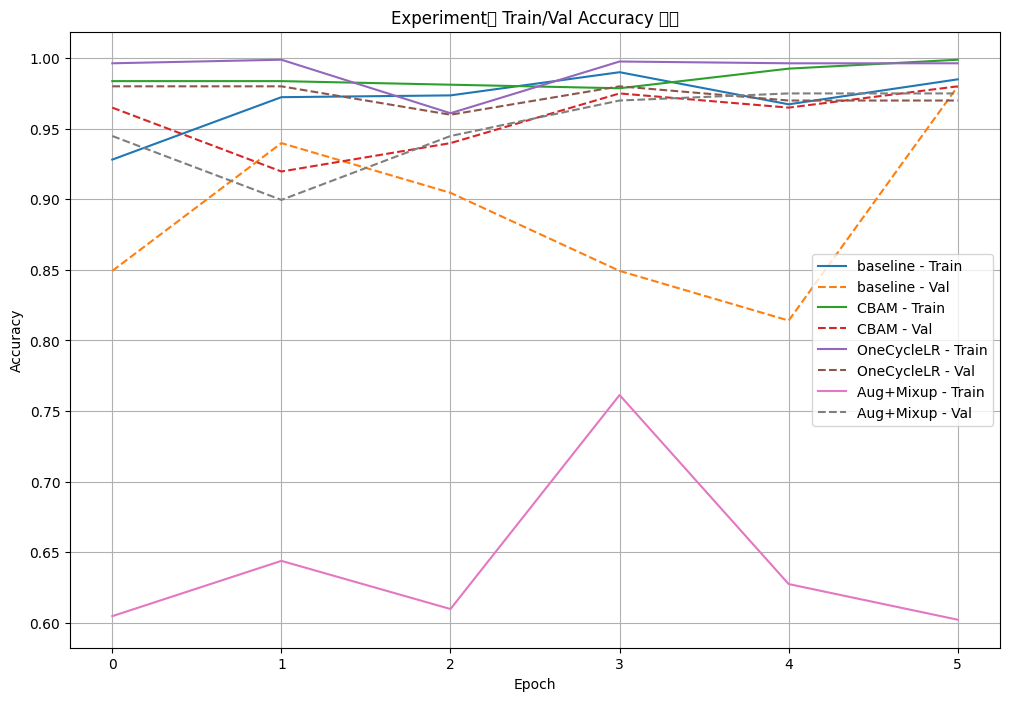

In [ ]:
# 셀 9: 각 실험별 train/val Accuracy 비교 시각화
plt.figure(figsize=(12,8))
for exp_name, history in training_histories.items():
    plt.plot(history['train_acc'], label=f"{exp_name} - Train")
    plt.plot(history['val_acc'], label=f"{exp_name} - Val", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Experiment별 Train/Val Accuracy 비교')
plt.legend()
plt.grid(True)
plt.show()


아래는 출력층 빼고는 얼린것


In [ ]:
num_epochs = 20

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


=== Baseline (Output Layer Only) 학습 ===
Epoch [1/20] - Train Loss: 0.6881, Train Acc: 0.8283 | Val Loss: 0.6619, Val Acc: 0.8995
Epoch [2/20] - Train Loss: 0.2693, Train Acc: 0.9407 | Val Loss: 0.4539, Val Acc: 0.8744
Epoch [3/20] - Train Loss: 0.2017, Train Acc: 0.9482 | Val Loss: 0.3002, Val Acc: 0.9447
Epoch [4/20] - Train Loss: 0.1573, Train Acc: 0.9684 | Val Loss: 0.2146, Val Acc: 0.9598
Epoch [5/20] - Train Loss: 0.1323, Train Acc: 0.9646 | Val Loss: 0.1381, Val Acc: 0.9698
Epoch [6/20] - Train Loss: 0.1134, Train Acc: 0.9785 | Val Loss: 0.1036, Val Acc: 0.9698
Epoch [7/20] - Train Loss: 0.1154, Train Acc: 0.9785 | Val Loss: 0.0881, Val Acc: 0.9799
Epoch [8/20] - Train Loss: 0.1003, Train Acc: 0.9760 | Val Loss: 0.0777, Val Acc: 0.9849
Epoch [9/20] - Train Loss: 0.0925, Train Acc: 0.9722 | Val Loss: 0.0720, Val Acc: 0.9749
Epoch [10/20] - Train Loss: 0.1067, Train Acc: 0.9634 | Val Loss: 0.0674, Val Acc: 0.9849
Epoch [11/20] - Train Loss: 0.0773, Train Acc: 0.9798 | Val Loss: 0.0

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch [1/20] - Train Loss: 1.2672, Train Acc: 0.6894 | Val Loss: 1.1869, Val Acc: 0.6231
Epoch [2/20] - Train Loss: 1.0487, Train Acc: 0.8687 | Val Loss: 0.9962, Val Acc: 0.6533
Epoch [3/20] - Train Loss: 0.8811, Train Acc: 0.8965 | Val Loss: 0.8276, Val Acc: 0.7437
Epoch [4/20] - Train Loss: 0.7784, Train Acc: 0.9078 | Val Loss: 0.6917, Val Acc: 0.8543
Epoch [5/20] - Train Loss: 0.6719, Train Acc: 0.9078 | Val Loss: 0.5906, Val Acc: 0.9095
Epoch [6/20] - Train Loss: 0.6112, Train Acc: 0.9015 | Val Loss: 0.5174, Val Acc: 0.9296
Epoch [7/20] - Train Loss: 0.5520, Train Acc: 0.9091 | Val Loss: 0.4637, Val Acc: 0.9397
Epoch [8/20] - Train Loss: 0.5018, Train Acc: 0.9318 | Val Loss: 0.4250, Val Acc: 0.9497
Epoch [9/20] - Train Loss: 0.4760, Train Acc: 0.9318 | Val Loss: 0.3950, Val Acc: 0.9548
Epoch [10/20] - Train Loss: 0.4475, Train Acc: 0.9205 | Val Loss: 0.3709, Val Acc: 0.9548
Epoch [11/20] - Train Loss: 0.4054, Train Acc: 0.9356 | Val Loss: 0.3491, Val Acc: 0.9548
Epoch [12/20] - Tra

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch [1/20] - Train Loss: 1.3367, Train Acc: 0.5795 | Val Loss: 1.3497, Val Acc: 0.5779
Epoch [2/20] - Train Loss: 1.2458, Train Acc: 0.7437 | Val Loss: 1.2564, Val Acc: 0.7387
Epoch [3/20] - Train Loss: 1.0321, Train Acc: 0.8460 | Val Loss: 1.0415, Val Acc: 0.7789
Epoch [4/20] - Train Loss: 0.7708, Train Acc: 0.9116 | Val Loss: 0.7779, Val Acc: 0.8643
Epoch [5/20] - Train Loss: 0.5673, Train Acc: 0.9432 | Val Loss: 0.5531, Val Acc: 0.9347
Epoch [6/20] - Train Loss: 0.4385, Train Acc: 0.9482 | Val Loss: 0.4032, Val Acc: 0.9598
Epoch [7/20] - Train Loss: 0.3555, Train Acc: 0.9533 | Val Loss: 0.3108, Val Acc: 0.9749
Epoch [8/20] - Train Loss: 0.2905, Train Acc: 0.9609 | Val Loss: 0.2518, Val Acc: 0.9648
Epoch [9/20] - Train Loss: 0.2632, Train Acc: 0.9722 | Val Loss: 0.2182, Val Acc: 0.9698
Epoch [10/20] - Train Loss: 0.2478, Train Acc: 0.9722 | Val Loss: 0.1951, Val Acc: 0.9698
Epoch [11/20] - Train Loss: 0.2075, Train Acc: 0.9735 | Val Loss: 0.1797, Val Acc: 0.9698
Epoch [12/20] - Tra

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch [1/6] - Train Loss: 1.3566, Train Acc: 0.3750 | Val Loss: 1.3342, Val Acc: 0.6482
Epoch [2/6] - Train Loss: 1.1280, Train Acc: 0.5467 | Val Loss: 1.1097, Val Acc: 0.6884
Epoch [3/6] - Train Loss: 0.9208, Train Acc: 0.5821 | Val Loss: 0.8439, Val Acc: 0.8090
Epoch [4/6] - Train Loss: 0.7920, Train Acc: 0.6023 | Val Loss: 0.6784, Val Acc: 0.8794
Epoch [5/6] - Train Loss: 0.7613, Train Acc: 0.6402 | Val Loss: 0.5920, Val Acc: 0.9347
Epoch [6/6] - Train Loss: 0.7498, Train Acc: 0.5707 | Val Loss: 0.5556, Val Acc: 0.9296


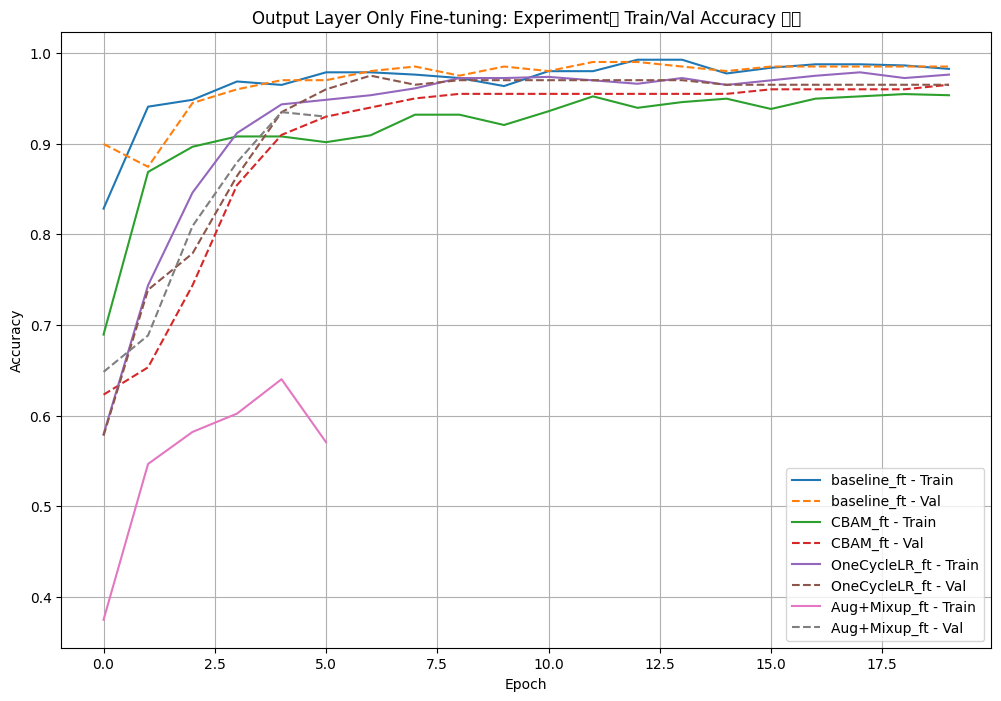

In [ ]:
# [출력층만 fine-tuning 실험 코드]
def freeze_except_classifier(model):
    """
    모델의 파라미터 중 'classifier' 관련 파라미터를 제외하고 모두 freeze합니다.
    """
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False
    return model

# 새로운 dictionary to store output-layer only experiment histories
training_histories_ft = {}

# --- Baseline (Output Layer Only) ---
baseline_model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                                     'nvidia_efficientnet_widese_b0', pretrained=True)
# fc 레이어 재설정
num_features = baseline_model_ft.classifier.fc.in_features
baseline_model_ft.classifier.fc = nn.Linear(num_features, num_classes)
baseline_model_ft = baseline_model_ft.to(device)
baseline_model_ft = freeze_except_classifier(baseline_model_ft)

print("=== Baseline (Output Layer Only) 학습 ===")
baseline_optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, baseline_model_ft.parameters()), lr=0.001)
baseline_history_ft = train_model(baseline_model_ft, train_loader, val_loader, criterion, baseline_optimizer_ft, num_epochs)
training_histories_ft['baseline_ft'] = baseline_history_ft

# --- CBAM (Output Layer Only) ---
# 새 모델 로드 후 CBAM 추가
baseline_model_for_cbam_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                                              'nvidia_efficientnet_widese_b0', pretrained=True)
num_features = baseline_model_for_cbam_ft.classifier.fc.in_features
baseline_model_for_cbam_ft.classifier.fc = nn.Linear(num_features, num_classes)
baseline_model_for_cbam_ft = baseline_model_for_cbam_ft.to(device)
model_with_cbam_ft = EfficientNetWithCBAM(baseline_model_for_cbam_ft, cbam_channels).to(device)
model_with_cbam_ft = freeze_except_classifier(model_with_cbam_ft)

print("=== CBAM (Output Layer Only) 학습 ===")
cbam_optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_with_cbam_ft.parameters()), lr=0.001)
cbam_history_ft = train_model(model_with_cbam_ft, train_loader, val_loader, criterion, cbam_optimizer_ft, num_epochs)
training_histories_ft['CBAM_ft'] = cbam_history_ft

# --- OneCycleLR (Output Layer Only) ---
baseline_model_for_oc_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                                            'nvidia_efficientnet_widese_b0', pretrained=True)
num_features = baseline_model_for_oc_ft.classifier.fc.in_features
baseline_model_for_oc_ft.classifier.fc = nn.Linear(num_features, num_classes)
baseline_model_for_oc_ft = baseline_model_for_oc_ft.to(device)
model_with_cbam_oc_ft = EfficientNetWithCBAM(baseline_model_for_oc_ft, cbam_channels).to(device)
model_with_cbam_oc_ft = freeze_except_classifier(model_with_cbam_oc_ft)
optimizer_oc_ft = optim.Adam(filter(lambda p: p.requires_grad, model_with_cbam_oc_ft.parameters()), lr=0.001)
scheduler_oc_ft = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_oc_ft,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs
)
print("=== OneCycleLR (Output Layer Only) 학습 ===")
oc_history_ft = train_model(model_with_cbam_oc_ft, train_loader, val_loader, criterion, optimizer_oc_ft, num_epochs, scheduler=scheduler_oc_ft)
training_histories_ft['OneCycleLR_ft'] = oc_history_ft

# --- 증강 + Mixup (Output Layer Only) ---
# 기존에 정의한 증강 transform(train_transform_aug, val_transform_aug)와 DataLoader(train_loader_aug, val_loader_aug) 사용
baseline_model_for_aug_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                                             'nvidia_efficientnet_widese_b0', pretrained=True)
num_features = baseline_model_for_aug_ft.classifier.fc.in_features
baseline_model_for_aug_ft.classifier.fc = nn.Linear(num_features, num_classes)
baseline_model_for_aug_ft = baseline_model_for_aug_ft.to(device)
model_with_cbam_aug_ft = EfficientNetWithCBAM(baseline_model_for_aug_ft, cbam_channels).to(device)
model_with_cbam_aug_ft = freeze_except_classifier(model_with_cbam_aug_ft)
optimizer_aug_ft = optim.Adam(filter(lambda p: p.requires_grad, model_with_cbam_aug_ft.parameters()), lr=0.001)
scheduler_aug_ft = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_aug_ft,
    max_lr=0.001,
    steps_per_epoch=len(train_loader_aug),
    epochs=num_epochs_aug
)
print("=== 증강 + Mixup (Output Layer Only) 학습 ===")
aug_history_ft = train_model_mixup(model_with_cbam_aug_ft, train_loader_aug, val_loader_aug,
                                   criterion, optimizer_aug_ft, num_epochs_aug, scheduler_aug_ft, use_mixup)
training_histories_ft['Aug+Mixup_ft'] = aug_history_ft

# --- 실험 결과 시각화 (Output Layer Only Fine-tuning) ---
plt.figure(figsize=(12,8))
for exp_name, history in training_histories_ft.items():
    plt.plot(history['train_acc'], label=f"{exp_name} - Train")
    plt.plot(history['val_acc'], label=f"{exp_name} - Val", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Output Layer Only Fine-tuning: Experiment별 Train/Val Accuracy 비교')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import sqlite3
import datetime
import os

# DB 파일을 저장할 디렉토리 지정 (Google Drive 경로)
db_dir = "/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/DB"
if not os.path.exists(db_dir):
    os.makedirs(db_dir)
db_path = os.path.join(db_dir, "training_logs.db")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 학습 기록 테이블 생성 (experiment: 실험 이름)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS training_logs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        experiment TEXT,
        epoch INTEGER,
        training_start_time TEXT,
        training_end_time TEXT,
        train_loss REAL,
        train_acc REAL,
        val_loss REAL,
        val_acc REAL
    )
''')
conn.commit()

for exp_name, history in training_histories_ft.items():
    num_epochs_exp = len(history['train_loss'])
    for epoch in range(num_epochs_exp):
        epoch_start_str = history.get('epoch_start', [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * num_epochs_exp)[epoch]
        epoch_end_str = history.get('epoch_end', [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * num_epochs_exp)[epoch]

        cursor.execute('''
            INSERT INTO training_logs (experiment, epoch, training_start_time, training_end_time, train_loss, train_acc, val_loss, val_acc)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            exp_name,
            epoch + 1,
            epoch_start_str,
            epoch_end_str,
            history['train_loss'][epoch],
            history['train_acc'][epoch],
            history['val_loss'][epoch],
            history['val_acc'][epoch]
        ))
conn.commit()
conn.close()
print("학습 기록이 DB에 저장되었습니다.")


학습 기록이 DB에 저장되었습니다.


In [ ]:
import sqlite3
import os

db_dir = "/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/DB"
db_path = os.path.join(db_dir, "training_logs.db")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('SELECT * FROM training_logs')
logs = cursor.fetchall()

print("저장된 학습 기록:")
for log in logs:
    print(log)
conn.close()


저장된 학습 기록:
(1, 'baseline_ft', 1, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.6988454759120941, 0.8068181818181818, 0.6637723164342756, 0.9296482412060302)
(2, 'baseline_ft', 2, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.28553859061665005, 0.9368686868686869, 0.43184263742149775, 0.9246231155778895)
(3, 'baseline_ft', 3, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.18471092632924668, 0.9570707070707071, 0.28966053736269776, 0.9346733668341709)
(4, 'baseline_ft', 4, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.16276701125833723, 0.9671717171717171, 0.1904405994930459, 0.9698492462311558)
(5, 'baseline_ft', 5, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.13878487216101754, 0.9696969696969697, 0.13383854603647588, 0.9748743718592965)
(6, 'baseline_ft', 6, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.12816084123621083, 0.9709595959595959, 0.10157419583905282, 0.9798994974874372)
(7, 'baseline_ft', 7, '2025-03-27 06:16:07', '2025-03-27 06:16:07', 0.08867268098725213, 0.9

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import os

def predict_image(model, image_path, transform, class_names):
    """
    지정된 이미지(image_path)를 불러와 transform 적용 후 모델 추론을 수행하고,
    예측 클래스와 해당 확률을 반환합니다.
    """
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, dim=1)
        predicted_label = class_names[predicted_idx.item()]
        predicted_prob = probs[0, predicted_idx.item()].item()
    return predicted_label, predicted_prob

# 실제 데이터를 저장한 폴더 경로 (사용자 환경에 맞게 수정)
real_data_dir = "/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/real_data"

# 추론에 사용할 4개의 이미지 파일명 (실제 파일명에 맞게 수정)
image_files = ["black spot.jpg", "citrus canker.jpeg", "fresh.jpeg", "greening citrus.jpeg"]

print("=== 실제 데이터 추론 결과 ===")
for img_file in image_files:
    img_path = os.path.join(real_data_dir, img_file)
    label, prob = predict_image(efficientnet, img_path, val_transform, class_names)
    print(f"이미지: {img_file} -> 예측 클래스: {label}, 확률: {prob*100:.2f}%")


=== 실제 데이터 추론 결과 ===
이미지: black spot.jpg -> 예측 클래스: grenning, 확률: 99.96%
이미지: citrus canker.jpeg -> 예측 클래스: fresh, 확률: 92.62%
이미지: fresh.jpeg -> 예측 클래스: fresh, 확률: 99.37%
이미지: greening citrus.jpeg -> 예측 클래스: fresh, 확률: 97.24%


Using cuda for inference


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Classes: ['blackspot', 'canker', 'fresh', 'grenning']
Train size: 792, Val size: 199
기존 fc 레이어 in_features: 1280
변경된 모델 구조:
EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
   

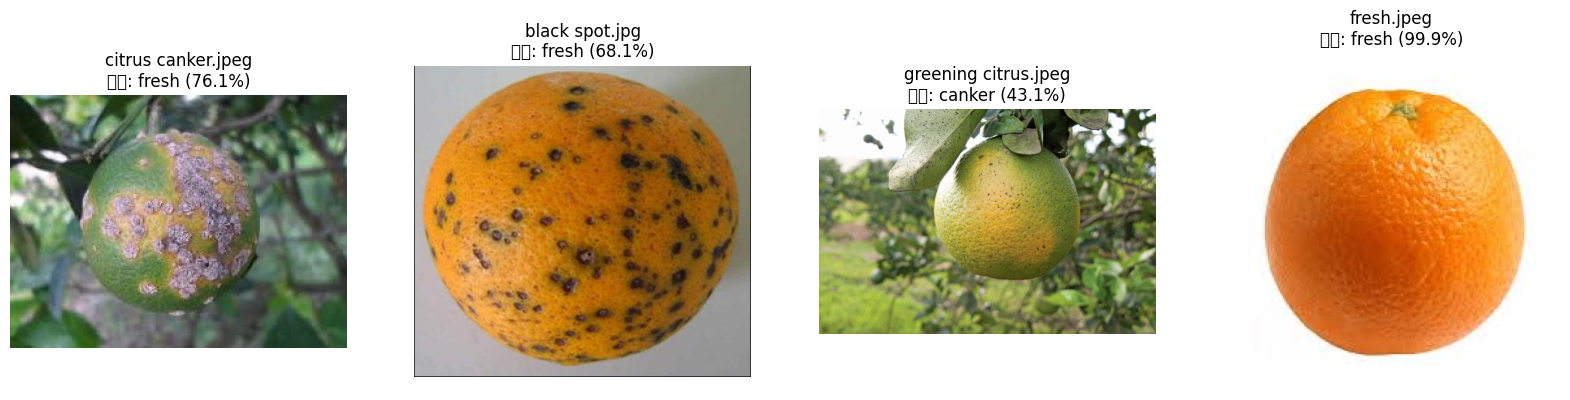

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline

# 1. device 설정
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

# 2. 모델 로드: EfficientNet-B0 Wide-SE (사전학습된 가중치)
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                              'nvidia_efficientnet_widese_b0', pretrained=True)
# 모델의 conv 기능 및 utils도 로드 (필요 시)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub',
                        'nvidia_convnets_processing_utils')
efficientnet.eval().to(device)

# 3. 데이터셋 및 전처리 설정
# 데이터셋 경로 (학습용 데이터셋 폴더)
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/train'

# Define the categories (ImageFolder의 하위 폴더 이름)
categories = ['blackspot', 'canker', 'fresh', 'grenning']

# 전처리: 학습과 검증에 동일하게 Resize, ToTensor, Normalize 적용
IMAGE_SIZE = (224, 224)
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터셋 로드 (ImageFolder 사용)
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)

# Train/Validation Split (80/20)
seed = 1234
torch.manual_seed(seed)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(seed))
# Validation set은 별도의 transform 적용
val_dataset.dataset.transform = val_transform

# DataLoader 준비
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 클래스 이름 및 수
class_names = full_dataset.classes
print(f'Classes: {class_names}')
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')
num_classes = len(class_names)

# 4. 모델 수정: fc 레이어 재설정 및 출력층만 학습 (Partial Fine-tuning)
num_features = efficientnet.classifier.fc.in_features
print("기존 fc 레이어 in_features:", num_features)
efficientnet.classifier.fc = nn.Linear(num_features, num_classes)
efficientnet = efficientnet.to(device)
print("변경된 모델 구조:")
print(efficientnet)

def freeze_except_classifier(model):
    """
    모델의 파라미터 중 'classifier' 관련 파라미터를 제외하고 모두 freeze합니다.
    """
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False
    return model

# 출력층만 미세조정하도록 모델 동결
baseline_model_ft = efficientnet  # 이미 efficientnet 객체에 classifier 재설정됨
baseline_model_ft = freeze_except_classifier(baseline_model_ft)

# 5. 학습 함수 정의 (간단한 버전)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss/total
        train_acc = correct/total

        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_loss = running_loss_val/total_val
        val_acc = correct_val/total_val

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    return history

# 6. 학습 수행
criterion = nn.CrossEntropyLoss()
baseline_optimizer_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, baseline_model_ft.parameters()), lr=0.001)
num_epochs = 20
print("=== Baseline (Output Layer Only) 학습 시작 ===")
baseline_history_ft = train_model(baseline_model_ft, train_loader, val_loader, criterion, baseline_optimizer_ft, num_epochs)

# 7. 실제 데이터에 대한 추론 함수 정의
def predict_image(model, image_path, transform, class_names):
    """
    지정된 이미지(image_path)를 불러와 transform 적용 후 모델 추론을 수행하고,
    예측 클래스와 해당 확률을 반환합니다.
    """
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, dim=1)
        predicted_label = class_names[predicted_idx.item()]
        predicted_prob = probs[0, predicted_idx.item()].item()
    return predicted_label, predicted_prob

# 8. 실제 데이터(real_data) 폴더 내 4개 이미지에 대해 추론 수행
# 실제 데이터 폴더 경로 (사용자 환경에 맞게 수정)
real_data_dir = "/content/drive/MyDrive/Colab Notebooks/개인/kakaotech/과제/개인과제/3월/8주차 - 개인프로젝트/real_data"
# 실제 파일명: "citrus canker.jpeg", "black spot.jpg", "greening citrus.jpeg", "fresh.jpeg"
image_files = ["citrus canker.jpeg", "black spot.jpg", "greening citrus.jpeg", "fresh.jpeg"]

# 예상 정답 (필요시)
expected_labels = {
    "citrus canker.jpeg": "canker",
    "black spot.jpg": "blackspot",
    "greening citrus.jpeg": "grenning",
    "fresh.jpeg": "fresh"
}

print("\n=== 실제 데이터 추론 결과 (출력층만 파인튜닝한 모델 사용) ===")
for img_file in image_files:
    img_path = os.path.join(real_data_dir, img_file)
    if not os.path.exists(img_path):
        print(f"파일 '{img_file}'이(가) 존재하지 않습니다. 파일명 및 경로를 확인하세요.")
        continue
    try:
        label, prob = predict_image(baseline_model_ft, img_path, val_transform, class_names)
        expected = expected_labels.get(img_file, "Unknown")
        print(f"이미지: {img_file} -> 예측 클래스: {label} ({prob*100:.2f}%), 예상: {expected}")
    except Exception as e:
        print(f"파일 '{img_file}' 처리 중 오류 발생: {e}")

# 선택적으로, 추론 결과를 시각화 (예: subplot 등)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(real_data_dir, img_file)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        label, prob = predict_image(baseline_model_ft, img_path, val_transform, class_names)
        ax.imshow(img)
        ax.set_title(f"{img_file}\n예측: {label} ({prob*100:.1f}%)")
        ax.axis('off')
plt.show()
